# Stochastic Simulation Assignment 2
- Dennis Curti (14526263)
- Sjoerd Dronkers (13420607)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import simpy as sim
import scipy.stats as sp

## General Functions

In [118]:
def customer(env, servers, name, service_rate):
    """
    Function to act as a customer.
    """

    arrival = env.now

    with servers.server.request() as request:
        yield request

        # Process the customer through the server.
        yield env.process(servers.processing(service_rate))
        leave_time = env.now

        # Store waiting time spent in the queue.
        servers.waiting_times.append(leave_time - arrival - servers.service_times[-1])

In [156]:
def setup(env, servers, n, no_customers, service_time, arrival_rate):
    """
    Main function to run the system.
    """

    # Go through the number of customers to be served.
    for i in range(no_customers):
        env.process(customer(env, servers, f'Person {i}', service_time))
        yield env.timeout(np.random.exponential(arrival_rate))

## Question 2

In [157]:
class Servers(object):
    """
    Class to simulate behaviour of the servers. It processes the customers for
    the pre determined service time and tracks this time.
    """

    def __init__(self, env, n, service_time):
        """
        Initialize Server object.
        self.waiting_times keeps track of the time spend in the queue.
        self.service_times tracks the time spend in the serves.
        """

        self.env = env
        self.server = sim.Resource(env, n)
        # self.service_time = service_time
        self.waiting_times = list()
        self.service_times = list()

    def processing(self, service_rate):
        """
        Process a customer for the determined service_time and store this time
        spent in self.service_times.
        """

        self.service_times.append(np.random.exponential(service_rate))
        yield self.env.timeout(self.service_times[-1])


In [158]:
def simulation(n, no_customers, service_time, arrival_rate, run_time) -> list:
    env = sim.Environment()
    servers = Servers(env, n, service_time)
    env.process(setup(env, servers, n, no_customers, service_time, arrival_rate))
    env.run(until=run_time)
    return servers.waiting_times, servers.service_times

In [117]:
# Check if it works for simple cases (Calculated by hand).
# Does not work anymore after switching from deterministic to memoryless
assert simulation(1, 2, 10, 5, 1000)[0][1] == 5
assert simulation(2, 2, 10, 5, 1000)[0][1] == 0
assert simulation(2, 3, 10, 3, 1000)[0][2] == 4

#### Run for rho=0.9

In [167]:
# Base parameters for rho=0.9
no_customers = 1000
service_rate = 0.9
arrival_rate = 1
total_time = 100000

# Simulation parameters
no_simulations = 1000
n = [1, 2, 4]

In [168]:
means_waiting = list()
stdev_waiting = list()
means_service = list()
stdev_service = list()

# Go through different number of servers.
for i in n:
    waiting = list()
    service = list()

    # Go through the number of simulationes needed.
    for j in range(no_simulations):
        simu = simulation(i, no_customers, service_rate, arrival_rate, total_time)
        waiting.append(np.mean(simu[0]))
        service.append(np.mean(simu[1]))

    # Store the results for each n.
    means_waiting.append(np.mean(waiting))
    stdev_waiting.append(np.std(waiting))
    means_service.append(np.mean(service))
    stdev_service.append(np.std(service))

    print(f'Simulations for {i} servers done.')


Text(0.5, 1.0, 'Average waiting time for different number of servers')

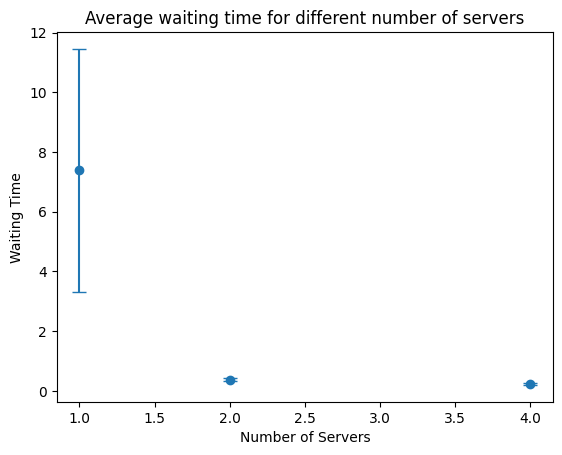

In [169]:
plt.errorbar(n, means_waiting, yerr=stdev_waiting, fmt='o', capsize=5, label='Data with Error Bars')
plt.xlabel('Number of Servers')
plt.ylabel('Waiting Time')
plt.title('Average waiting time for different number of servers')

In [171]:
means_waiting

[7.382604502173761, 0.3751742089775439, 0.22556527643501587]

In [172]:
stdev_waiting

[4.0680016653077375, 0.0520582521431326, 0.025873280694812862]

#### Run for rho=0.99

In [173]:
# Base parameters for rho=0.99
no_customers = 1000
service_rate = 0.99
arrival_rate = 1
total_time = 100000

# Simulation parameters
no_simulations = 1000
n = [1, 2, 4]

In [174]:
means_waiting = list()
stdev_waiting = list()
# means_service = list()
# stdev_service = list()

# Go through different number of servers.
for i in n:
    waiting = list()
    service = list()

    # Go through the number of simulationes needed.
    for j in range(no_simulations):
        simu = simulation(i, no_customers, service_rate, arrival_rate, total_time)
        waiting.append(np.mean(simu[0]))
        # service.append(np.mean(simu[1]))

    # Store the results for each n.
    means_waiting.append(np.mean(waiting))
    stdev_waiting.append(np.std(waiting))
    # means_service.append(np.mean(service))
    # stdev_service.append(np.std(service))

    print(f'Simulations for {i} servers done.')

Simulations for [1, 2, 4] servers done.
Simulations for [1, 2, 4] servers done.
Simulations for [1, 2, 4] servers done.


Text(0.5, 1.0, 'Average waiting time for different number of servers')

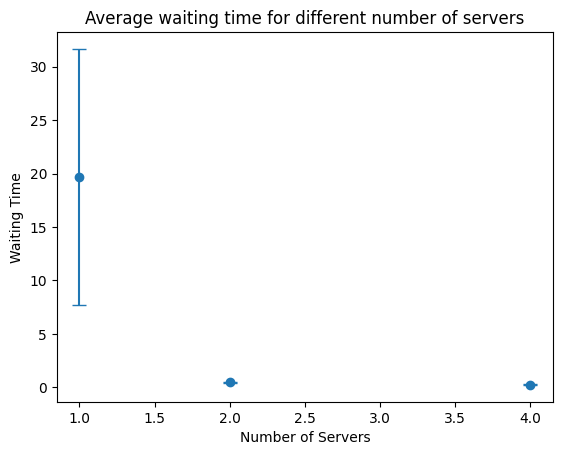

In [175]:
plt.errorbar(n, means_waiting, yerr=stdev_waiting, fmt='o', capsize=5, label='Data with Error Bars')
plt.xlabel('Number of Servers')
plt.ylabel('Waiting Time')
plt.title('Average waiting time for different number of servers')

In [176]:
means_waiting

[19.689975778824234, 0.4716065792203263, 0.24915836656625867]

In [177]:
stdev_waiting

[11.969396303883014, 0.06835050879085551, 0.026401609733863313]

## Question 3

In [178]:
class Priority_Servers(object):
    """
    Class to simulate behaviour of the servers that prioritze lower values.
    """

    def __init__(self, env, n, service_time):
        """
        Initialize Server object.
        """

        self.env = env
        self.server = sim.PriorityResource(env, n)
        self.service_time = service_time
        self.waiting_times = list()
        self.service_times = list()

    def processing(self, service_time):
        self.service_times.append(service_time)
        yield self.env.timeout(self.service_time)

In [179]:
def simulation_priority(n, no_customers, service_time, arrival_rate, run_time) -> list:
    env = sim.Environment()
    servers = Priority_Servers(env, n, service_time)
    env.process(setup(env, servers, n, no_customers, service_time, arrival_rate))
    env.run(until=run_time)
    return servers.waiting_times, servers.service_times

In [183]:
# Base parameters for rho=0.9
no_customers = 1000
service_rate = 0.99
arrival_rate = 1
total_time = 100000

# Simulation parameters
no_simulations = 100
n = [1, 2, 4]

#### Run priority queue for rho 0.9

In [184]:
means_waiting = list()
stdev_waiting = list()
# means_service = list()
# stdev_service = list()

# Go through different number of servers.
for i in n:
    waiting = list()
    service = list()

    # Go through the number of simulationes needed.
    for j in range(no_simulations):
        simu = simulation_priority(i, no_customers, service_rate, arrival_rate, total_time)
        waiting.append(np.mean(simu[0]))
        # service.append(np.mean(simu[1]))

    # Store the results for each n.
    means_waiting.append(np.mean(waiting))
    stdev_waiting.append(np.std(waiting))
    # means_service.append(np.mean(service))
    # stdev_service.append(np.std(service))

    print(f'Simulations for {i} servers done.')

Simulations for 1 servers done.
Simulations for 2 servers done.
Simulations for 4 servers done.


Text(0.5, 1.0, 'Average waiting time for different number of servers')

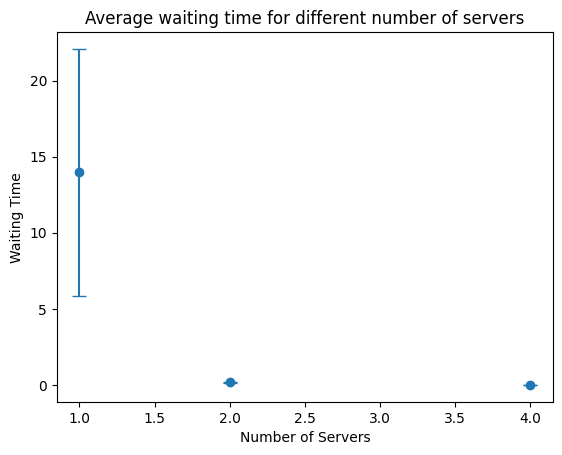

In [185]:
plt.errorbar(n, means_waiting, yerr=stdev_waiting, fmt='o', capsize=5, label='Data with Error Bars')
plt.xlabel('Number of Servers')
plt.ylabel('Waiting Time')
plt.title('Average waiting time for different number of servers')

#### Run priority queue for rho 0.99

## Question 4

#### Simulations for M/D/1 and M/D/n queues

In [ ]:
class MD_Servers(object):
    """
    Class to simulate behaviour of the servers that prioritze lower values.
    """

    def __init__(self, env, n, service_time):
        """
        Initialize Server object.
        """

        self.env = env
        self.server = sim.Resource(env, n)
        self.service_time = service_time
        self.waiting_times = list()
        self.service_times = list()

    def processing(self, service_time):
        self.service_times.append(service_time)
        yield self.env.timeout(self.service_time)